# TreeDetect Background Notebook

## Introduction

This notebook explains the functions and analyses in this repository. These are:

- Download RGB and infrared photos
- Preprocess the data and compute a vegetation index
- Find blobs in the NDVI (trees)
- Georeference and save the generated blobs
- Divide a big area into smaller areas for efficient processing

To run this notebook clone the branch first and cd to the folder.


In [1]:
import numpy as np
import math
from skimage.feature import blob_log
import matplotlib
from matplotlib import pyplot as plt
from skimage import io

## Loading Data

The data is fetched from a WebMapService. To interface with such a service, this repository uses OWSLib. 
As an example, we will look at RGB (Red-Green-Blue) and NIR (Near-InfraRed) data from the Dutch Government's Geo-information portal <a href="https://www.pdok.nl/">PDOK</a>. Note that you can look at all options that the WMS service provides via the <a href="https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0?SERVICE=WCS&request=GetCapabilities&version=1.3.0">GetCapabilities</a> call that WMS servers expose. This is necessary to, for example, find out which coordinate reference systems (CRS) they provide, and which map Layers they provide.

In [2]:
from owslib.wms import WebMapService

rgb_wms = WebMapService('https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0', version='1.3.0')
nir_wms = WebMapService('https://service.pdok.nl/hwh/luchtfotocir/wms/v1_0', version='1.3.0')

For the current example, let's look at a section of land with some trees! To find your own bounding box you can use websites such as <a href='https://boundingbox.klokantech.com/'>this bounding box tool at klokantech.com</a> (do note: as we use a WMS service for dutch geo-data, either choose a bounding box for a region in the Netherlands, or use another WMS service). Also note that this example notebook doesn't 'cut up' the bounding box into multiple sub-regions yet for efficient processing, so make sure not to pick giant plots of land. These can be analyzed through the analysis pipeline. 

This bounding box tool uses the EPSG:4326 coordinate system, a widely used CRS. The below example will load data for a bounding box corresponding to the 'Sportveldstraat' ('sporting field street') in Linne, NL.

In [3]:
bbox = [5.9314065054, 51.1468310473, 5.9353466704, 51.1497919454]
pixel_size = 0.25 # how many meters are in a pixel? Note that this may differ for each WMS you use!
coord_crs = 'EPSG:4326'

In [4]:
def haversine(lon1, lat1, lon2, lat2):
    '''
    Returns the haversine distance, i.e. the distance between two lon/lat coordinates in meters
    See also: https://rosettacode.org/wiki/Haversine_formula#Python

    Parameters
    lon1 : float - the longitude of the first coordinate 
    lat1 : float - the latitude of the first coordinate
    lon2 : float - the longitude of the second coordinate
    lat2 : float - the latitude of the second coordinate

    Returns
    dist: float - the distance between the two coordinates in meters
    '''

    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))

    km_to_m = 1000
    radius_of_earth_in_km = 6371
    dist = c * radius_of_earth_in_km * km_to_m

    return dist

In [5]:
lon1 = bbox[0]
lat1 = bbox[1]
lon2 = bbox[2]
lat2 = bbox[3]
dist_x = haversine(lon1, lat1, lon2, lat1) # distance in m
dist_y = haversine(lon1, lat1, lon1, lat2)

After looking at the Capabilities that the server exposes, we find that the WMS gives us access to certain file formats, as well as certain map layers. We'll choose the following. 

In [6]:
layers_rgb = ['Actueel_ortho25']
layers_nir = ['Actueel_ortho25IR']
format = 'image/jpeg'

Now, let's fetch some images from the servers we specified before (RGB and NIR). As OWSLib gives us a response ubject, we will first have to read what's in the response, then read it into a (for our purposes) more workable format through skimage.

In [7]:
rgb_img = rgb_wms.getmap(layers=layers_rgb,
                 srs=coord_crs,
                 bbox=bbox,
                 size=(dist_x/pixel_size,dist_y/pixel_size),
                 format=format
)

nir_img = nir_wms.getmap(layers=layers_nir,
                 srs=coord_crs,
                 bbox=bbox,
                 size=(dist_x/pixel_size, dist_y/pixel_size),
                 format=format
)

In [8]:
rgb_img = io.imread(rgb_img.read(), plugin='imageio')
nir_img = io.imread(nir_img.read(), plugin='imageio')

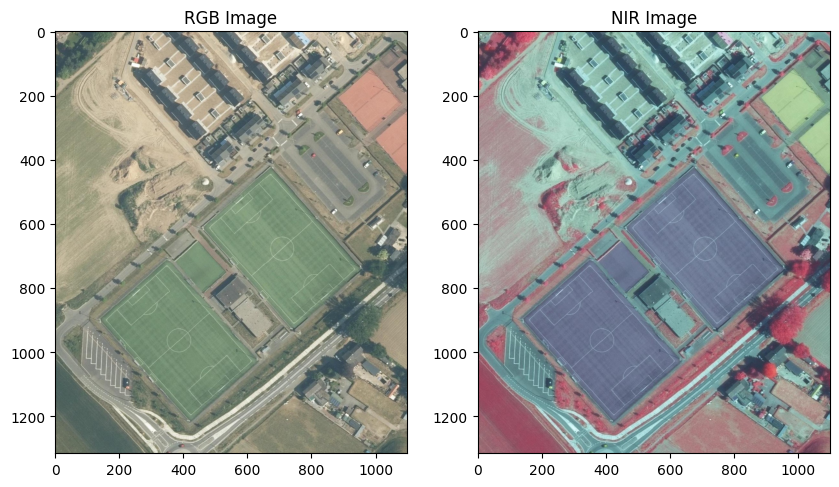

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10,20))
axes[0].imshow(rgb_img)
axes[0].set_title('RGB Image')
axes[1].imshow(nir_img)
axes[1].set_title('NIR Image')
plt.show()

Images are often given as n-dimensional matrices, in which each dimension encodes a different color-band. Usually, these consist of 3 dimensions, one coding for Red, one for Green, and one for Blue (hence 'RGB') due to the way monitors display colors.

In an RGB image, 
- Red light is given by the Red channel,
- Green light given by the Green channel,
- Blue by the Blue channel.

In a NIR image, 
- Near-Infrared light is given in the RED channel,
- 'light that is in the Red band of the visual spectrum' is now given in the GREEN channel.
- 'light that is in the Green band of the visual spectrum' is now given in the BLUE channel.

Notice in the image, for example, how the reddish roof in the top-right corner APPEARS green in the NIR image. This is because the red light is 'shifted' one channel into the green. Notice similarly how the green sports fields APPEAR blue in the NIR image, as the green light is shifted one channel into the blue.

Finally, notice how all green VEGETATION appears RED in the NIR image. This is because vegetation reflects Near-Infrared MORE than non-vegetative green objects. 

Also notice, then, that the sport fields are likely artificial grass, as it does NOT reflect infrared.

## Calculating the NDVI

This property, that the relatively higher ratio of NIR light vs other light that vegetation reflects compared to non-vegetation, can be modeled by various vegetation indices. A widely used on is called the <a href="https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index">Normalized Difference Vegetation Index (NDVI)</a>, which uses the ratio between infrared and regular red light to determine vegetation, where values > 0.2 or 0.3 are often taken as indicative of vegetation. 

Before calculating the NDVI, we will normalize the nir and red channels. As JPEG uses an 8-bit value, the max value in a jpeg pixel is 255.

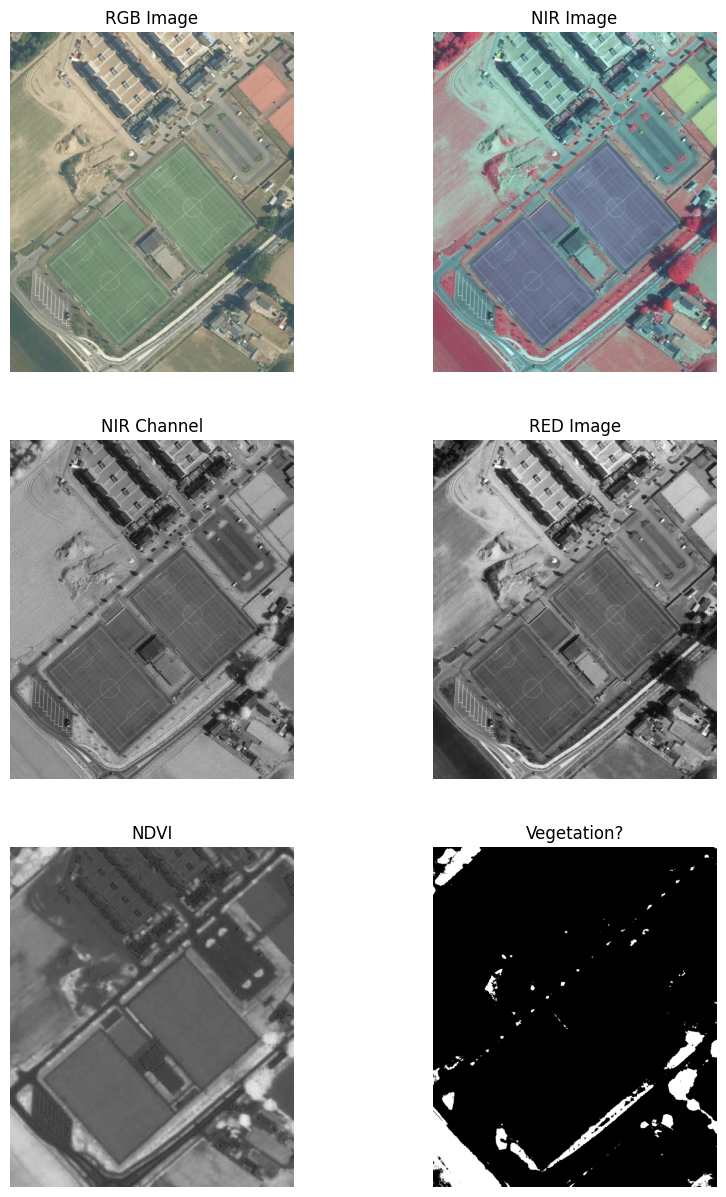

In [10]:
# separate nir and red channels from the nir image
nir = nir_img[:,:,0]
red = nir_img[:,:,1]

# normalize red and nir values
max_value = 255
nir = nir / max_value
red = red / max_value

# calculate the ndvi as: (nir - red) / (nir + red)
ndvi = (nir - red) / (nir + red)
veg = ndvi > 0.2

# plot the result
fig, axes = plt.subplots(3,2, figsize=(10,15))
axes[0,0].imshow(rgb_img)
axes[0,0].set_title('RGB Image')
axes[0,0].axis('off')
axes[0,1].imshow(nir_img)
axes[0,1].set_title('NIR Image')
axes[0,1].axis('off')
axes[1,0].imshow(nir, cmap = 'gray')
axes[1,0].set_title('NIR Channel')
axes[1,0].axis('off')
axes[1,1].imshow(red, cmap = 'gray')
axes[1,1].set_title('RED Image')
axes[1,1].axis('off')
axes[2,0].imshow(ndvi, cmap = 'gray')
axes[2,0].set_title('NDVI')
axes[2,0].axis('off')
axes[2,1].imshow(veg, cmap = 'gray')
axes[2,1].set_title('Vegetation?')
axes[2,1].axis('off')
plt.show()

## Blob detection in the NDVI

Trees are gaussian-shaped objects in the vegetation. So, in order to find the trees in this image, we can blob detect using, for example, the Laplacian of the Gaussian method.

In [11]:
minrad = 2.5 # RADIUS of the smallest gaussian kernel in meters. Must be >= 3 (pixels) * pixel_size in m! E.g. 3 * 0.25 = 0.
maxrad = 20 # RADIUS of the biggest gaussian kernel in meters. 
steprad = 0.5 # steps to sample the scale space with, in meters. Should always be >= pixel_size in m, e.g. 0.25
threshold_rel_blob_peaks = 0.0025 # rel_threshold * max(image) is the threshold for when a peak is considered a local maximum, rather than randomness
blob_overlap_threshold = 0.5 # float, the ratio/amount of overlap in terms of the smaller blob's radius two blobs can have before being pruned.

# generate scales used for generating the scale space
minradpix = minrad / pixel_size # minimum radius of tree crowns in pixels
maxradpix = maxrad / pixel_size # max radius of tree crown in pixels
difrad = maxrad - minrad # difference in gaussian blob radius in meters
difradpix = difrad / pixel_size # difference in radius in pixels
stepradpix = steprad / pixel_size # step size for the scale range (between min and max radius) in pixels
nscales = int(difradpix / stepradpix) # how many scales we must create between min and max radius

blobs = blob_log(
            ndvi, 
            min_sigma = minradpix,
            max_sigma = maxradpix,
            num_sigma = nscales,
            overlap = blob_overlap_threshold,
            threshold_rel = threshold_rel_blob_peaks
)

In [12]:
# reshape the blobs based on the return type of the blob detect method: 
# from [Y-indexed-from-top-left, X, Scale] to [X.Y-indexed-from-bottom-left, Scale]
blobs = blobs.astype(np.float32)
blobs[:,0:2] = np.flip(blobs[:,0:2], axis=1) # flip x and y coordinates
blobs[:,2] = np.multiply(blobs[:,2], pixel_size) # substitute the radius of the blobs in pixels, to their radius in meters
blobs = np.c_[blobs, blobs[:,2] * 2] # add column for diameter
blobs = np.c_[blobs, blobs[:,2] * 2 * math.pi] # add column for circumference
blobs = np.c_[blobs, blobs[:,2]**2 * math.pi] # add column for area of blobs

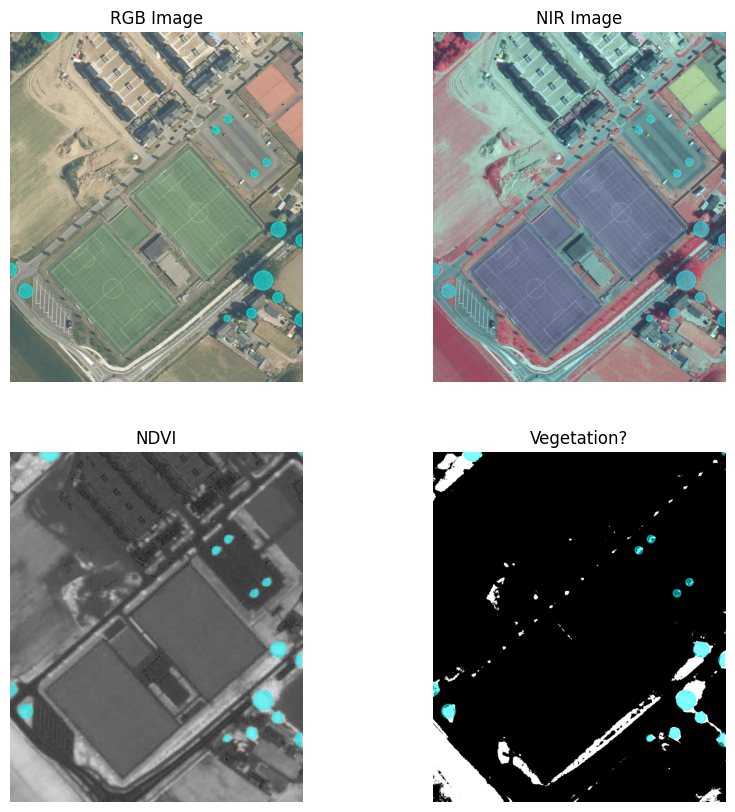

In [13]:
# plot the result
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].imshow(rgb_img)
axes[0,0].scatter(blobs[:,0],blobs[:,1],s=blobs[:,5], c='cyan', alpha = 0.5)
axes[0,0].set_title('RGB Image')
axes[0,0].axis('off')
axes[0,1].imshow(nir_img)
axes[0,1].scatter(blobs[:,0],blobs[:,1],s=blobs[:,5], c='cyan', alpha = 0.5)
axes[0,1].set_title('NIR Image')
axes[0,1].axis('off')
axes[1,0].imshow(ndvi, cmap = 'gray')
axes[1,0].scatter(blobs[:,0],blobs[:,1],s=blobs[:,5], c='cyan', alpha = 0.5)
axes[1,0].set_title('NDVI')
axes[1,0].axis('off')
axes[1,1].imshow(veg, cmap = 'gray')
axes[1,1].scatter(blobs[:,0],blobs[:,1],s=blobs[:,5], c='cyan', alpha = 0.5)
axes[1,1].set_title('Vegetation?')
axes[1,1].axis('off')
plt.show()

## Saving the results

Now all that's left is to save them to a csv file geo-referenced to a certain coordinate reference system.

In [14]:
# note that the y-axis orientation in the image data above are 'flipped' with regards to our CSR. 
# for this reason, we will need to 'flip' the found points around the y-axis.
# in the repository code, this is done based on the image size that is specified in the config. 
# For now, we set it to the vertical length of the image.
blobs[:,1] = ndvi.shape[0] - blobs[:,1] # flip vertical pixels coordinates

In [15]:
def haversine_inv(lon1, lat1, dx=0, dy=0):
    '''
    Returns new lon lat coordinate from beginpoint and offset in meters

    Parameters:
    lon1 : float - longitude of the beginpoint
    lat1 : float - latitude of the beginpoint
    dx : float - meters in the west-east direction at which we want to find the coordinates of the endpoint
    dy : float - meters in the north-south direction at which we want to find the coordinates of the endpoint

    Returns:
    coord: tuple of 2 floats - the longitude/latitude coordinates, which are dx,dy meters from the input coordinate 

    '''
    m_to_km = 1000
    dy = dy/m_to_km # convert to km
    dx = dx/m_to_km
    radius_of_earth_in_km = 6371
    lon2 = lon1 + (dx / radius_of_earth_in_km) * (180/math.pi) / np.cos(lat1*math.pi/180)
    lat2 = lat1 + (dy / radius_of_earth_in_km) * (180/math.pi) 
    coord = (lon2, lat2)
    return coord

In [16]:
# transform the found points to their geo-referenced
lon1 = bbox[0]
lat1 = bbox[1]
blobs[:,0:2] = np.multiply(blobs[:,0:2], pixel_size, casting = 'safe') # change each point's pixel coordinates in the image, to meters from the beginning
blobs[:,0:2] = np.array([haversine_inv(lon1, lat1, blobs[b,0], blobs[b,1]) for b in range(blobs.shape[0])]) # get coords for each point

In [17]:
# then save to csv (if wanted)
save_to_file = True
if save_to_file:
    filepath = 'example_trees.csv'
    np.savetxt(filepath, blobs, delimiter=",", header = "longitude,latitude,radius,diameter,circumference,area", comments='')

You will now be able to load it into <a href="https://www.qgis.org/en/site/">QGIS</a>. via the `Layer > Data Source Manager > Delimited Text` option.

## The Analysis Pipeline

In order to not create memory problems, a bounding box (which may span many kilometers both in latitude and longitude) may need to be cut up into smaller sub-bounding boxes. The exact size can be specified in the config file in the `pixel_size` parameter, which specifies how many measurements each sub-bounding box will span.

The analysis pipeline then applies this analysis to all the bounding boxes, and aggregates all results into one csv file at the end. It also has funcitonality to retry if certain data fetch requests fail, to skip sub-bounding boxes that were already done earlier, and to keep track of failed analyses or data fetch requests (which can be redone in isolation).

To use this, it is best to check out the `single_analysis_main.py` script for an example.